In [5]:
import yaml
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from doa.utils import create_dataset
import os

Here we demonstrate the usage of our method for predictions made by ExtraTreesRegressor models. Our method can be used with any kind of model.

# 1. Create molecular descriptors

We can use Mordred to quickly generate a set of descriptors. We have provides a function in doa/utils to prepare a dataset in 
the form required by the res of the DoA calculations 

In [42]:
_  = create_dataset(csv_path='sample_data/data.csv', 
                smiles_column='SMILES',
                logs_column='Solubility', 
                save_path='sample_data/des_data.csv')

The descriptors will be saved to 'sample_data/des_data.csv'. 

# 2. Outlier detection

Now we can run machine learning models to find the errors associated with each molecule. The configuratons are stored in the "../scripts/configs/main.yaml" file.

Execute the following command to run a large number of ML models to find the prediction errors made for each molecule

In [43]:
config_path = '../scripts/configs/main.yaml'
!python ../scripts/run_models.py --config $config_path  --run-id=1

Once completed, we will have "smiles_error_et_{i}.pkl" files in the folder specified by "res_path" in the configuration file (i.e ../scripts/configs/main.yaml).

Next we have to determine how to seperate outliers and inliers. After ordering the molecules in the descending order of the outliernerss, we select n percentage of molecules having the largest outlierness scores as outliers and the others as inliers. We remove the n outliers and using the remaining non outliers, we do cross validated prediction of the target property and obtain the mean prediction accuracies (RMSE, R2). We repeat this process for several n values (0.95 to to 0.65). The following command executes this procedeure.

In [10]:
!python ../scripts/post_process.py  --config $config_path

min : 11 mean:  25.0 sdev:  4.52990066116245
percent:  0.95
percent:  0.9
percent:  0.85
percent:  0.8
percent:  0.75
percent:  0.7
percent:  0.65


Using the "find_olpercent" function, we can obtain R2 scores corresponding to different n values.

In [11]:
from doa.detect import find_olpercent
opt = yaml.load(open(config_path), Loader=yaml.FullLoader)
olp_versus_r2, enpls, df = find_olpercent(data_path=opt['data_path'], res_path=opt['res_path'], 
                                          rerun_threshold_detection=False)

The dataframe "olp_versus_r2" gives us the cross validate R2 and RMSE for non outliers when olp percent of outliers are removed. We see that as the outlier percentage (olp) increases, we get better R2, RMSE values for the corresponding inliers.

In [12]:
olp_versus_r2

,r2,rmse,olp,prolp
0,0.855391,0.862258,5.0,0
1,0.875820,0.781190,10.0,1
2,0.879089,0.747201,15.0,2
3,0.900009,0.664421,20.0,3
4,0.906867,0.622902,25.0,4
5,0.915320,0.592967,30.0,5
6,0.928350,0.540011,35.0,6


In the {res_path}/ol_thresh_res directory the outliers and inliners for each of the olp value are saved.

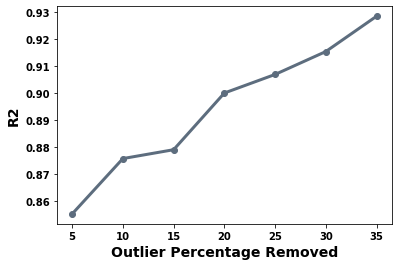

In [37]:
plt.plot(olp_versus_r2.olp, olp_versus_r2.r2,  color='#5D6D7E', marker='o', ls='-', lw=3);

plt.ylabel("R2", fontsize=14, fontweight='bold')
plt.xlabel("Outlier Percentage Removed", fontsize=14, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold');
plt.yticks(fontsize=10, fontweight='bold');

Now we have to determine which R2 score value should be used to seperate outliers and inliers. The molecules giving a R2 score greater than this value will be considered as non outliers and the others will be outliers.

In [38]:
r2_threshold = 0.90 # we select 0.90 as the R2 threshold.

In [15]:
print(olp_versus_r2.loc[np.where((olp_versus_r2.r2> r2_threshold ))[0][0], 'olp'])
th_file_id = olp_versus_r2.loc[np.where((olp_versus_r2.r2> r2_threshold ))[0][0], 'prolp']
print(th_file_id)

20.0
3


So, using 0.90 as the R2 results in 20% of outleirs which correspond to out 4th calculation (calc_id = 3 in the "olp_versus_r2" table).

We can use save_ols function to save our final outliers and inliers. The arguments to this function are {res_path} and the calculation id which is 3 in our case.

In [16]:
from doa.utils import save_ols

In [17]:
save_ols(opt['res_path'], th_file_id)

Now we are ready to find the domains of applicability. What are the domain boundaries and what are the expected prediction accurcies for each domain.

# 3. Feature based filtering

### Get the DoA table

To get the DoA table we need 

<ol>
<li>the errors made by molecule in the train set (saved in {res_path}/errors.csv ).</li>
<li>Seleceted outliers (saved in {res_path}/outliers.csv ) and </li>
<li>Inliers (saved in {res_path}/non_outliers.csv ).</li>
<li>Data used to obtain prediction error which are at {data_path}  </li>
</ol>

In [41]:
from doa import doa

In [22]:
errors = pd.read_csv('results/runs/errors.csv')
df_ol = pd.read_csv(os.path.join(opt['res_path'], 'outliers.csv'))
df_nol = pd.read_csv(os.path.join(opt['res_path'], 'non_outliers.csv'))
all_data = pd.read_csv(opt['data_path'])

The following cell generates the DoA table.

In [23]:
doa_obj = doa.find_th(ol=df_ol, nol=df_nol, all_data=all_data, enpls=errors)
# remove features that are more than 0.95 correlated
new_th = doa_obj.remove_corr_from_propth(0.95)
# get the domain of applicability tables
doa_orig, doa_olness = doa_obj.get_doa_table()
doa_obj.save_data(opt['res_path'])
doa_olness['all_out_pcnt'] = doa_olness['#ols']/all_data.shape[0]

/opt/anaconda3/envs/doa/lib/python3.8/site-packages/doa/doa.py:171: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.df_ref_all.loc[:, self.cols] = self.df_ref_all.loc[:, self.cols].astype(float)
100%|█████████████████████████████████████████████████████████████████████████████| 721/721 [00:00<00:00, 1297.94it/s]


using IQR from definition


100%|██████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 852.64it/s]


In [27]:
print(doa_olness.loc[:20, ['prop', 'threshold', 'direction', 'all_out_pcnt']].to_markdown(index=False))

| prop        |    threshold | direction   |   all_out_pcnt |
|:------------|-------------:|:------------|---------------:|
| IC0         |     0.657481 | >=          |          0.002 |
| IC1         |     0.814787 | >=          |          0.004 |
| Mpe         |     0.86574  | >=          |          0.003 |
| IC2         |     1.60164  | >=          |          0.023 |
| IC3         |     1.81215  | >=          |          0.028 |
| AATS0dv     |    16.6811   | <=          |          0.036 |
| AATSC0dv    |     7.06984  | <=          |          0.031 |
| bpol        |    47.9571   | <=          |          0.048 |
| SRW02       |     1.96951  | >=          |          0.031 |
| CIC0        |     1.09343  | >=          |          0.016 |
| Mi          |     1.07587  | >=          |          0.028 |
| ATSC1p      |    -2.37158  | >=          |          0.054 |
| SaaCH       |    22.3919   | <=          |          0.025 |
| ATSC1m      |  -178.072    | >=          |          0.027 |
| JGT10 

### Run descriptor based filtering

In [28]:
train = pd.read_csv(opt['data_path'])
test = pd.read_csv('sample_data/test.csv')

In [29]:
from doa.fbf import fbf_results

In [32]:
# create the object
fbf_obj = fbf_results(df_ref=train, df_train=train, df_test=test, save_path=opt['res_path'])
# train a model using train set
model, scaler, features = fbf_obj.get_model_scaler()
# do feature based filtering
doa_results, all_outsmiles, ol_test_smiles = fbf_obj.get_doa_results(doa=doa_olness, r2_th=.95)
doa_results['n_test_percent'] = 100*doa_results['n_test_ols']/test.shape[0]

100%|███████████████████████████████████████████████████████████████████████████████| 174/174 [00:02<00:00, 63.44it/s]


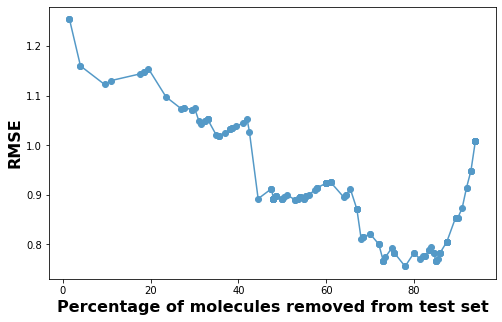

In [33]:
plt.figure(figsize = (8,5));
plt.plot(doa_results.n_test_percent, doa_results.rmse,  color='#5499C7', ls='-', marker='o', label = 'Domain based Filtering');
plt.xlabel('Percentage of molecules removed from test set', fontsize=16, fontweight='bold');
plt.ylabel('RMSE', fontsize=16, fontweight='bold');